#Imports

In [ ]:
!nvidia-smi

In [ ]:
!df -h
!cat /proc/meminfo
!cat /proc/cpuinfo

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import sys
from tensorflow import keras 
from keras import layers 
import os
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")

In [7]:
(train_data, test_data), ds_info = tfds.load(name = 'cars196', as_supervised = True, 
                                             shuffle_files = True, with_info=True, split=["train","test"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incompleteG9M2EW/cars196-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incompleteG9M2EW/cars196-test.tfrecord*...:   0%|          |…

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.1.0. Subsequent calls will reuse this data.


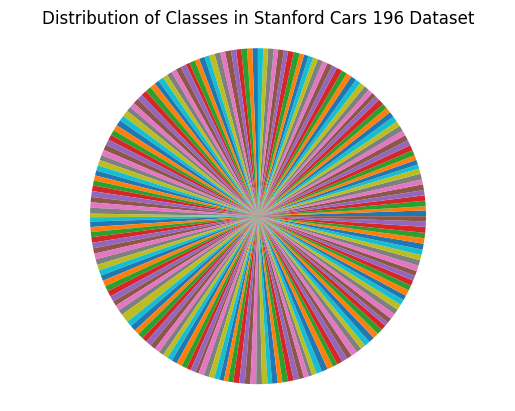

In [26]:
# Get the number of classes and class names
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

counts = [0] * num_classes
for _,target in  train_data.take(len(train_data)):
  counts[target.numpy()]+=1

plt.pie(counts)
plt.axis('equal')
plt.title('Distribution of Classes in Stanford Cars 196 Dataset')
plt.show()

# Preprocessing

In [ ]:
IMG_SIZE = (299,299)
IMG_HEIGHT = 299 
IMG_WIDTH = 299
NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names

In [ ]:
def preprocess_img(image, label):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  return tf.cast(image, dtype=tf.float32), label

train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=200).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Inception Net

In [ ]:
data_augModel = keras.Sequential([
  layers.RandomZoom(.2),
  layers.RandomContrast(.2),
  layers.RandomHeight(.2),
  layers.RandomWidth(.2) 
])

In [ ]:
inception_model =  keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3), pooling='avg')
for layer in inception_model.layers[:5]:
   layer.trainable = False

x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(inception_model.output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs = inception_model.input, outputs = outputs)

In [ ]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 149, 149, 32  864         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_577 (Batch  (None, 149, 149, 32  96         ['conv2d_564[0][0]']             
 Normalization)                 )                                                          

#Training 

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

model_historyFE = model.fit(train_data, epochs = 10000, validation_data=test_data, 
                            validation_steps = 25)

Epoch 1/10000
255/255 [==============================] - 139s 272ms/step - loss: 5.7820 - accuracy: 0.0047 - val_loss: nan - val_accuracy: 0.0050
Epoch 2/10000
255/255 [==============================] - 59s 227ms/step - loss: 5.3339 - accuracy: 0.0056 - val_loss: 5.2844 - val_accuracy: 0.0037
Epoch 3/10000
255/255 [==============================] - 57s 220ms/step - loss: 5.3039 - accuracy: 0.0052 - val_loss: 12.0280 - val_accuracy: 0.0050
Epoch 4/10000
255/255 [==============================] - 59s 227ms/step - loss: 5.2804 - accuracy: 0.0071 - val_loss: 15.8297 - val_accuracy: 0.0012
Epoch 5/10000
255/255 [==============================] - 58s 223ms/step - loss: 5.2384 - accuracy: 0.0086 - val_loss: 5.2158 - val_accuracy: 0.0050
Epoch 6/10000
255/255 [==============================] - 58s 224ms/step - loss: 5.1900 - accuracy: 0.0082 - val_loss: 29.1433 - val_accuracy: 0.0113
Epoch 7/10000
255/255 [==============================] - 57s 220ms/step - loss: 5.1800 - accuracy: 0.0104 - val

KeyboardInterrupt: ignored

# Plot

In [ ]:
inception_model =  keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3), pooling='avg')
for layer in inception_model.layers[:5]:
   layer.trainable = False

x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(inception_model.output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs = inception_model.input, outputs = outputs)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

model_history = model.fit(train_data, epochs = 100, validation_data=test_data, 
                            validation_steps = 25)

Epoch 1/100
255/255 [==============================] - 111s 237ms/step - loss: 5.7608 - accuracy: 0.0070 - val_loss: 394.3900 - val_accuracy: 0.0037
Epoch 2/100
255/255 [==============================] - 58s 225ms/step - loss: 5.3254 - accuracy: 0.0063 - val_loss: 5.2820 - val_accuracy: 0.0050
Epoch 3/100
255/255 [==============================] - 60s 230ms/step - loss: 5.2927 - accuracy: 0.0042 - val_loss: 18.7150 - val_accuracy: 0.0050
Epoch 4/100
255/255 [==============================] - 57s 220ms/step - loss: 5.2924 - accuracy: 0.0071 - val_loss: 26.2106 - val_accuracy: 0.0050
Epoch 5/100
255/255 [==============================] - 59s 229ms/step - loss: 5.2803 - accuracy: 0.0081 - val_loss: 5.2759 - val_accuracy: 0.0037
Epoch 6/100
255/255 [==============================] - 59s 230ms/step - loss: 5.2777 - accuracy: 0.0090 - val_loss: 8.3186 - val_accuracy: 0.0050
Epoch 7/100
255/255 [==============================] - 60s 229ms/step - loss: 5.2727 - accuracy: 0.0098 - val_loss: 10.

In [ ]:
import matplotlib.pyplot as plt

# Assuming model_history is the history returned by model.fit()

# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



NameError: ignored

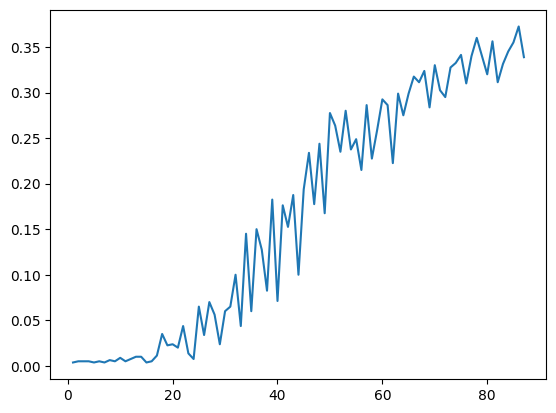

In [ ]:
# colab ran out of gpu limit so had to manually write and plot the val_accuracy
vals = [
0.0037,
0.0050,
0.0050,
0.0050,
0.0037,
0.0050,
0.0037,
0.0063,
0.0050,
0.0088,
0.0050,
0.0075,
0.0100,
0.0100,
0.0037,
0.0050,
0.0113,
0.0350,
0.0225,
0.0237,
0.0200,
0.0437,
0.0137,
0.0075,
0.0650,
0.0338,
0.0700,
0.0562,
0.0237,
0.0600,
0.0650,
0.1000,
0.0437,
0.1450,
0.0600,
0.1500,
0.1275,
0.0825,
0.1825,
0.0712,
0.1762,
0.1525,
0.1875,
0.1000,
0.1937,
0.2338,
0.1775,
0.2438,
0.1675,
0.2775,
0.2637,
0.2350,
0.2800,
0.2375,
0.2488,
0.2150,
0.2862,
0.2275,
0.2587,
0.2925,
0.2862,
0.2225,
0.2988,
0.2750,
0.2988,
0.3175,
0.3113,
0.3237,
0.2837,
0.3300,
0.3025,
0.2950,
0.3275,
0.3325,
0.3413,
0.3100,
0.3400,
0.3600,
0.3400,
0.3200,
0.3562,
0.3113,
0.3313,
0.3450,
0.3550,
0.3725,
0.3388
]

epochs = [i+1 for i in range(len(vals))]
import matplotlib.pyplot as plt
plt.plot(epochs,vals)